In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn

from scipy.ndimage.interpolation import zoom
from sklearn.utils import shuffle
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import os
import time
import h5py

# keras
from keras.models import Sequential
from keras.layers import Input, Conv3D, Flatten, Dense, MaxPooling3D, Dropout
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import Sequence

from config import *
from utils import specificity
from utils import sensitivity

Using TensorFlow backend.


In [3]:
# Start timing
start_time = time.time()

In [4]:
# Tensorflow settings
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session, get_session

config = tf.ConfigProto()
config.gpu_options.visible_device_list = "6"
sess = tf.Session(config=config)
set_session(sess)

In [5]:
dtype = np.float32
result_dir = "/analysis/share/Ritter/models/fabi/ADNI/pretraining_paper/"

In [6]:
!mkdir -p $result_dir

In [7]:
# load hdf5 files and extract columns
train_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/train_2yr_and_unique_screening-921_subjects-96_114_96_shape-masked.h5", 'r')
holdout_h5 = h5py.File("/analysis/share/ADNI/HDF5_files/test_2yr_and_unique_screening-150_subjects-96_114_96_shape-masked.h5", 'r')

X_train, y_train, files_train = train_h5['X'], train_h5['y'], train_h5["files"]
X_holdout, y_holdout = holdout_h5['X'], holdout_h5['y']

In [8]:
# convert data to numpy arrays
X_train = np.expand_dims(np.array(X_train, dtype=dtype), 4)
y_train = np.array(y_train)

X_holdout = np.expand_dims(np.array(X_holdout, dtype=dtype), 4)
y_holdout = np.array(y_holdout)

In [9]:
print("Total datset length: {}".format(len(y_train)))
print("Number of healthy controls: {}".format(len(np.array(y_train)[np.array(y_train)==0.])))
print("Number of AD patients: {}".format(len(np.array(y_train)[np.array(y_train)==1.])))

Total datset length: 921
Number of healthy controls: 464
Number of AD patients: 457


In [10]:
class ADNIDataset(Sequence):
    def __init__(self, X, y, transform=None, batch_size=4, z_factor=None, shuffle=True, mask=None):
        self.X = X
        self.y = y
        self.transform = transform
        self.batch_size = batch_size
        self.z_factor = z_factor
        self.shuffle = shuffle
        self.mask = mask
        
    def __len__(self):
        return int(np.ceil(len(self.y)/self.batch_size))
    
    def __getitem__(self, idx):
        # add BET
        image = np.expand_dims(self.X[idx * self.batch_size:(idx + 1) * self.batch_size],5)
        label = np.array(self.y[idx * self.batch_size:(idx + 1) * self.batch_size], dtype=np.int8)
        
        if self.mask is not None:
            for i in range(image.shape[0]):
                image[i] *= self.mask
        
        for transformation in self.transform:
            image = transformation(image)
        
        return image, label
    
    def on_epoch_end(self):
        if self.shuffle:
            self.X, self.y = shuffle(self.X, self.y)

In [11]:
# images are already masked
mask = None

# Model

In [12]:
def SixtyFourNet(input_shape, drop_rate=0., weight_dcay=0.):
    model = Sequential()
    model.add(Conv3D(64, kernel_size=3, 
                     input_shape=(input_shape[1], input_shape[2], input_shape[3], 1), 
                     activation='elu', padding='valid', name='Conv_1'))
    model.add(MaxPooling3D(pool_size=3, name='Pool_1'))
    model.add(Dropout(drop_rate))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_2'))

    model.add(MaxPooling3D(pool_size=3, name='Pool_2'))
    model.add(Dropout(drop_rate))

    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_3',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(Conv3D(64, kernel_size=3, padding='valid', activation='elu', name='Conv_4',
                     kernel_regularizer=l2(weight_dcay)))
    model.add(MaxPooling3D(pool_size=3, name='Pool_4'))
    model.add(Dropout(drop_rate))

    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Normalization

In [13]:
files_train = np.array(files_train)

In [14]:
names_train = [item[53:53+10].decode('utf-8') for item in files_train]

### Normalize min-max

In [15]:
for i in range(len(X_train)):
    X_train[i] -= np.min(X_train[i])
    X_train[i] /= np.max(X_train[i])
    
for i in range(len(X_holdout)):
    X_holdout[i] -= np.min(X_holdout[i])
    X_holdout[i] /= np.max(X_holdout[i])

### Normalize by voxel and split data

In [16]:
GSS = GroupShuffleSplit(n_splits=1, test_size=0.15, random_state=22)
indices = list(GSS.split(names_train, groups=names_train))[0]
train_idx, val_idx = indices[0], indices[1]

mean = np.mean(X_train[train_idx], axis=0)
std = np.std(X_train[train_idx], axis=0)
X_train = (X_train - mean) / (std)

In [17]:
# shuffle indices test
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)

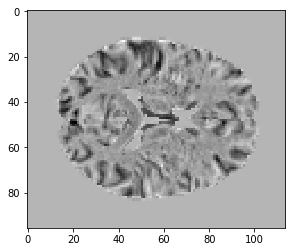

In [18]:
plt.imshow(X_train[4][:,:,46,0], cmap='gray')
plt.show()

# Training

Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 39s 49ms/step - loss: 2.0482 - acc: 0.5062 - val_loss: 1.7348 - val_acc: 0.4513
Epoch 2/45
808/808 [==============================] - 36s 45ms/step - loss: 1.5812 - acc: 0.6015 - val_loss: 1.5914 - val_acc: 0.4867
Epoch 3/45
808/808 [==============================] - 36s 44ms/step - loss: 1.2680 - acc: 0.6473 - val_loss: 1.0491 - val_acc: 0.7257
Epoch 4/45
808/808 [==============================] - 36s 45ms/step - loss: 1.0147 - acc: 0.7228 - val_loss: 1.1609 - val_acc: 0.6460
Epoch 5/45
808/808 [==============================] - 36s 44ms/step - loss: 0.8948 - acc: 0.7550 - val_loss: 0.8695 - val_acc: 0.7345
Epoch 6/45
808/808 [==============================] - 35s 44ms/step - loss: 0.7369 - acc: 0.7970 - val_loss: 0.9394 - val_acc: 0.6903
Epoch 7/45
808/808 [==============================] - 36s 45ms/step - loss: 0.6594 - acc: 0.8230 - val_loss: 0.8181 - val_acc: 0.6549
Epoch 8/45
808/8

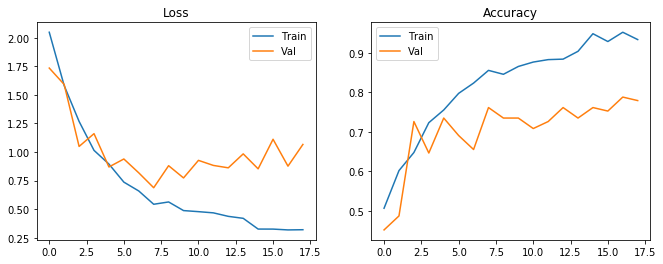

Final epoch results:
Balanced Accuracy: 76.53 %
Sensitivity: 90.32 %
Specificity: 62.75 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 45ms/step - loss: 2.0457 - acc: 0.5000 - val_loss: 1.7588 - val_acc: 0.4513
Epoch 2/45
808/808 [==============================] - 36s 44ms/step - loss: 1.6835 - acc: 0.5817 - val_loss: 1.3721 - val_acc: 0.7699
Epoch 3/45
808/808 [==============================] - 35s 44ms/step - loss: 1.3175 - acc: 0.6411 - val_loss: 1.3152 - val_acc: 0.6726
Epoch 4/45
808/808 [==============================] - 35s 43ms/step - loss: 1.0634 - acc: 0.7290 - val_loss: 0.9380 - val_acc: 0.7611
Epoch 5/45
808/808 [==============================] - 36s 44ms/step - loss: 0.8827 - acc: 0.7698 - val_loss: 0.8368 - val_acc: 0.7257
Epoch 6/45
808/808 [==============================] - 35s 44ms/step - loss: 0.7839 - acc: 0.7748 - val_loss: 0.8190 - val_acc: 0.7699
Epoch 7/45
808/808 [==============================] - 35s 44

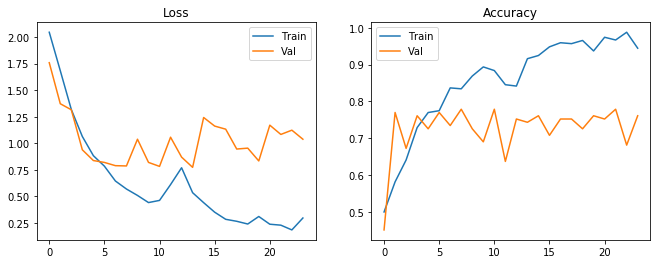

Final epoch results:
Balanced Accuracy: 75.09 %
Sensitivity: 85.48 %
Specificity: 64.71 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 36s 45ms/step - loss: 1.9974 - acc: 0.5347 - val_loss: 1.9399 - val_acc: 0.5487
Epoch 2/45
808/808 [==============================] - 35s 44ms/step - loss: 1.6361 - acc: 0.5916 - val_loss: 1.5363 - val_acc: 0.5752
Epoch 3/45
808/808 [==============================] - 35s 44ms/step - loss: 1.2765 - acc: 0.6535 - val_loss: 1.1731 - val_acc: 0.6814
Epoch 4/45
808/808 [==============================] - 36s 44ms/step - loss: 1.0583 - acc: 0.7327 - val_loss: 1.1171 - val_acc: 0.6372
Epoch 5/45
808/808 [==============================] - 36s 45ms/step - loss: 1.0440 - acc: 0.7005 - val_loss: 1.4097 - val_acc: 0.5044
Epoch 6/45
808/808 [==============================] - 36s 45ms/step - loss: 0.9222 - acc: 0.7116 - val_loss: 1.1196 - val_acc: 0.6106
Epoch 7/45
808/808 [==============================] - 36s 44

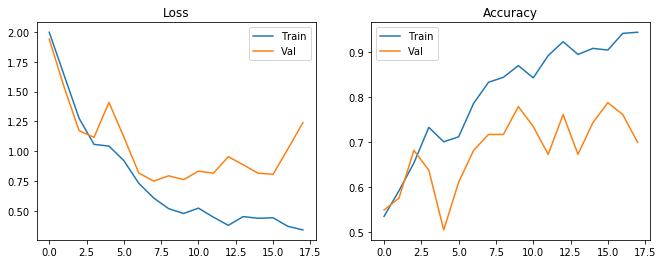

Final epoch results:
Balanced Accuracy: 68.93 %
Sensitivity: 79.03 %
Specificity: 58.82 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 45ms/step - loss: 1.9651 - acc: 0.5334 - val_loss: 1.6182 - val_acc: 0.5664
Epoch 2/45
808/808 [==============================] - 36s 44ms/step - loss: 1.5883 - acc: 0.5495 - val_loss: 1.3239 - val_acc: 0.6726
Epoch 3/45
808/808 [==============================] - 36s 44ms/step - loss: 1.2424 - acc: 0.6522 - val_loss: 1.2674 - val_acc: 0.4690
Epoch 4/45
808/808 [==============================] - 35s 43ms/step - loss: 1.0779 - acc: 0.6795 - val_loss: 1.2279 - val_acc: 0.6460
Epoch 5/45
808/808 [==============================] - 35s 44ms/step - loss: 0.8551 - acc: 0.7649 - val_loss: 0.8437 - val_acc: 0.7876
Epoch 6/45
808/808 [==============================] - 35s 44ms/step - loss: 0.6750 - acc: 0.8094 - val_loss: 0.9708 - val_acc: 0.6637
Epoch 7/45
808/808 [==============================] - 36s 44

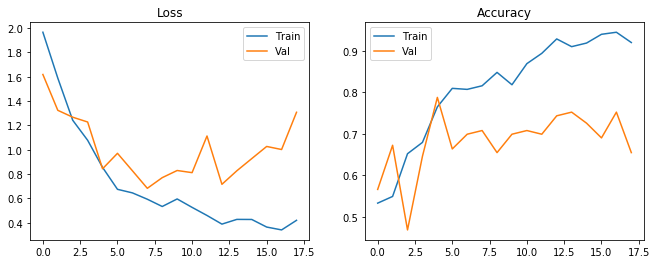

Final epoch results:
Balanced Accuracy: 64.90 %
Sensitivity: 70.97 %
Specificity: 58.82 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 46ms/step - loss: 2.0668 - acc: 0.5396 - val_loss: 1.9510 - val_acc: 0.4513
Epoch 2/45
808/808 [==============================] - 35s 44ms/step - loss: 1.6141 - acc: 0.5470 - val_loss: 1.4570 - val_acc: 0.5221
Epoch 3/45
808/808 [==============================] - 35s 44ms/step - loss: 1.3217 - acc: 0.5903 - val_loss: 1.2479 - val_acc: 0.5841
Epoch 4/45
808/808 [==============================] - 35s 44ms/step - loss: 1.0919 - acc: 0.6757 - val_loss: 1.0307 - val_acc: 0.7080
Epoch 5/45
808/808 [==============================] - 36s 44ms/step - loss: 0.9345 - acc: 0.7054 - val_loss: 0.7787 - val_acc: 0.7434
Epoch 6/45
808/808 [==============================] - 36s 44ms/step - loss: 0.7551 - acc: 0.7871 - val_loss: 0.7903 - val_acc: 0.8142
Epoch 7/45
808/808 [==============================] - 36s 44

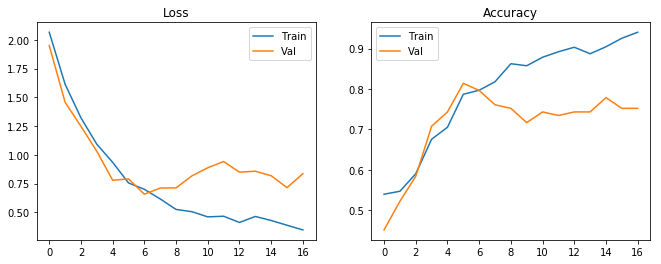

Final epoch results:
Balanced Accuracy: 73.94 %
Sensitivity: 87.10 %
Specificity: 60.78 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 46ms/step - loss: 1.9542 - acc: 0.5309 - val_loss: 1.6431 - val_acc: 0.5487
Epoch 2/45
808/808 [==============================] - 36s 45ms/step - loss: 1.5702 - acc: 0.5569 - val_loss: 1.2898 - val_acc: 0.6549
Epoch 3/45
808/808 [==============================] - 36s 44ms/step - loss: 1.2727 - acc: 0.6386 - val_loss: 0.9977 - val_acc: 0.7788
Epoch 4/45
808/808 [==============================] - 36s 44ms/step - loss: 0.9729 - acc: 0.7488 - val_loss: 1.0755 - val_acc: 0.6726
Epoch 5/45
808/808 [==============================] - 36s 44ms/step - loss: 0.9233 - acc: 0.7401 - val_loss: 1.1531 - val_acc: 0.5929
Epoch 6/45
808/808 [==============================] - 36s 44ms/step - loss: 0.8266 - acc: 0.7574 - val_loss: 0.8142 - val_acc: 0.7434
Epoch 7/45
808/808 [==============================] - 35s 44

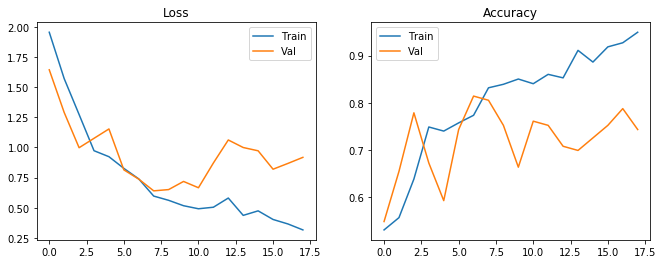

Final epoch results:
Balanced Accuracy: 73.31 %
Sensitivity: 83.87 %
Specificity: 62.75 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 38s 47ms/step - loss: 2.0120 - acc: 0.5161 - val_loss: 1.5455 - val_acc: 0.6991
Epoch 2/45
808/808 [==============================] - 36s 44ms/step - loss: 1.5572 - acc: 0.6213 - val_loss: 1.3346 - val_acc: 0.6372
Epoch 3/45
808/808 [==============================] - 35s 44ms/step - loss: 1.1848 - acc: 0.7191 - val_loss: 1.1025 - val_acc: 0.7168
Epoch 4/45
808/808 [==============================] - 36s 44ms/step - loss: 1.0625 - acc: 0.7252 - val_loss: 0.9187 - val_acc: 0.7699
Epoch 5/45
808/808 [==============================] - 36s 44ms/step - loss: 0.9055 - acc: 0.7512 - val_loss: 1.0512 - val_acc: 0.6106
Epoch 6/45
808/808 [==============================] - 35s 44ms/step - loss: 0.7408 - acc: 0.7970 - val_loss: 0.9402 - val_acc: 0.7080
Epoch 7/45
808/808 [==============================] - 35s 44

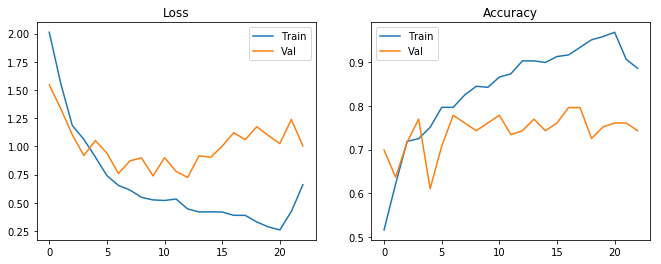

Final epoch results:
Balanced Accuracy: 74.35 %
Sensitivity: 74.19 %
Specificity: 74.51 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 46ms/step - loss: 2.1190 - acc: 0.5161 - val_loss: 1.7767 - val_acc: 0.5044
Epoch 2/45
808/808 [==============================] - 36s 44ms/step - loss: 1.6315 - acc: 0.5446 - val_loss: 1.4366 - val_acc: 0.5487
Epoch 3/45
808/808 [==============================] - 35s 44ms/step - loss: 1.3093 - acc: 0.6262 - val_loss: 1.1020 - val_acc: 0.7080
Epoch 4/45
808/808 [==============================] - 35s 44ms/step - loss: 1.0663 - acc: 0.7054 - val_loss: 0.9634 - val_acc: 0.7257
Epoch 5/45
808/808 [==============================] - 36s 44ms/step - loss: 0.9189 - acc: 0.7302 - val_loss: 1.0002 - val_acc: 0.6195
Epoch 6/45
808/808 [==============================] - 36s 44ms/step - loss: 0.8074 - acc: 0.7550 - val_loss: 0.8266 - val_acc: 0.7080
Epoch 7/45
808/808 [==============================] - 36s 44

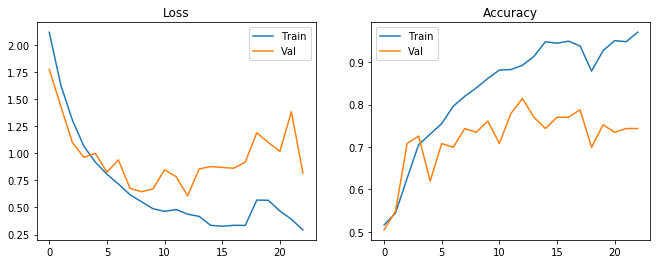

Final epoch results:
Balanced Accuracy: 74.00 %
Sensitivity: 77.42 %
Specificity: 70.59 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 46ms/step - loss: 1.9805 - acc: 0.5210 - val_loss: 1.7155 - val_acc: 0.5398
Epoch 2/45
808/808 [==============================] - 35s 44ms/step - loss: 1.5861 - acc: 0.5384 - val_loss: 1.3360 - val_acc: 0.5487
Epoch 3/45
808/808 [==============================] - 35s 44ms/step - loss: 1.2460 - acc: 0.6460 - val_loss: 1.1478 - val_acc: 0.6814
Epoch 4/45
808/808 [==============================] - 36s 44ms/step - loss: 0.9472 - acc: 0.7611 - val_loss: 1.0243 - val_acc: 0.6814
Epoch 5/45
808/808 [==============================] - 35s 44ms/step - loss: 0.7799 - acc: 0.7847 - val_loss: 1.1454 - val_acc: 0.7168
Epoch 6/45
808/808 [==============================] - 36s 44ms/step - loss: 0.6608 - acc: 0.8366 - val_loss: 0.8662 - val_acc: 0.7699
Epoch 7/45
808/808 [==============================] - 36s 44

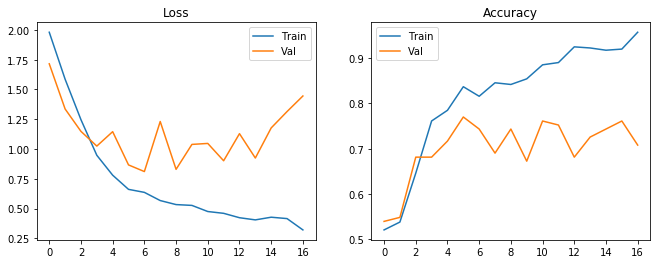

Final epoch results:
Balanced Accuracy: 69.39 %
Sensitivity: 83.87 %
Specificity: 54.90 %
Train on 808 samples, validate on 113 samples
Epoch 1/45
808/808 [==============================] - 37s 46ms/step - loss: 1.9824 - acc: 0.5235 - val_loss: 1.8035 - val_acc: 0.4513
Epoch 2/45
808/808 [==============================] - 36s 44ms/step - loss: 1.6093 - acc: 0.5470 - val_loss: 1.2573 - val_acc: 0.7522
Epoch 3/45
808/808 [==============================] - 36s 44ms/step - loss: 1.2012 - acc: 0.6658 - val_loss: 0.9840 - val_acc: 0.7876
Epoch 4/45
808/808 [==============================] - 36s 44ms/step - loss: 0.9502 - acc: 0.7426 - val_loss: 0.8475 - val_acc: 0.7611
Epoch 5/45
808/808 [==============================] - 35s 43ms/step - loss: 0.7764 - acc: 0.8020 - val_loss: 0.7673 - val_acc: 0.7611
Epoch 6/45
808/808 [==============================] - 36s 44ms/step - loss: 0.6556 - acc: 0.8329 - val_loss: 0.7156 - val_acc: 0.7965
Epoch 7/45
808/808 [==============================] - 36s 44

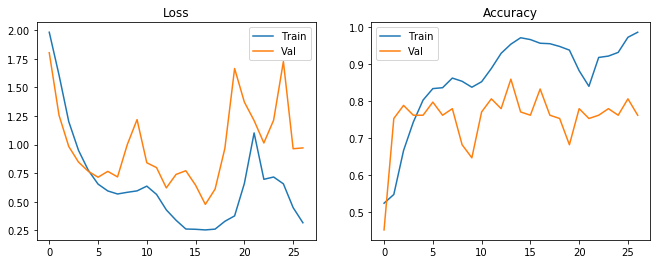

Final epoch results:
Balanced Accuracy: 74.75 %
Sensitivity: 88.71 %
Specificity: 60.78 %


In [21]:
# training args
lr = 0.001
lr_decay = 0.

num_trials = 10
patience = 10
store_models = True

best_epoch_acc = []
final_epoch_sens = []
final_epoch_spec = []

for i in range(num_trials):
    # init model
    model = SixtyFourNet(drop_rate=0.3, weight_dcay=0.01, input_shape=X_train.shape)
    opti = Adam(lr=lr, decay=lr_decay)
    model.compile(loss='binary_crossentropy', optimizer=opti, metrics=['accuracy'])
    
    #callbacks
    earlystopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
    model_checkpoint = ModelCheckpoint(os.path.join(result_dir, "model_trial_%i.h5" %i), monitor='val_acc', verbose=0, save_best_only=True, mode='max')

    if store_models:
        callbacks = [earlystopping, model_checkpoint]
    else:
        callbacks = [earlystopping]
    
    # Start training
    history = model.fit(
        X_train[train_idx],
        y_train[train_idx],
        epochs=num_epochs,
        batch_size=b,
        validation_data=(X_train[val_idx],y_train[val_idx]),
        callbacks=callbacks,
        shuffle=True
    )
    training_time = time.time() - start_time
    # Plot training curves
    plt.figure(figsize=(11, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["Train", "Val"])
    plt.title("Loss")
    plt.subplot(1, 2, 2)
    plt.plot(history.history["acc"])
    plt.plot(history.history["val_acc"])
    plt.legend(["Train", "Val"])
    plt.title("Accuracy")
    plt.show()    
    # Evaluation
    y_pred = model.predict(X_train[val_idx], batch_size=1).flatten() # predict and turn into 1-dimensional array
    sens = sensitivity(y_train[val_idx], y_pred>0.5)
    spec = specificity(y_train[val_idx], y_pred>0.5)
    # Store results
    best_epoch = np.argmax(history.history["val_acc"])
    best_epoch_acc.append(history.history["val_acc"][best_epoch])
    final_epoch_sens.append(sens)
    final_epoch_spec.append(spec)
    # Print results
    print("Final epoch results:")
    print("Balanced Accuracy: {:.2f} %".format(((sens + spec) * 100) / 2))
    print("Sensitivity: {:.2f} %".format(sens * 100))
    print("Specificity: {:.2f} %".format(spec * 100))

In [22]:
print("All best val accuracies: {}".format(best_epoch_acc))
print("Average best validation accuracy over {} trials: {:.5f} (std: {:.5f})".format(num_trials, np.mean(best_epoch_acc), np.std(best_epoch_acc)))

All best val accuracies: [0.7876106194690266, 0.7787610619469026, 0.7876106194690266, 0.7876106194690266, 0.8141592920353983, 0.8141592920353983, 0.7964601769911505, 0.8141592920353983, 0.7699115044247787, 0.8584070796460177]
Average best validation accuracy over 10 trials: 0.80088 (std: 0.02415)


In [23]:
print("Final epochs sensitivity: {}".format(final_epoch_sens))
print("Final epochs specificity: {}".format(final_epoch_spec))

Final epochs sensitivity: [0.9032258064516129, 0.8548387096774194, 0.7903225806451613, 0.7096774193548387, 0.8709677419354839, 0.8387096774193549, 0.7419354838709677, 0.7741935483870968, 0.8387096774193549, 0.8870967741935484]
Final epochs specificity: [0.6274509803921569, 0.6470588235294118, 0.5882352941176471, 0.5882352941176471, 0.6078431372549019, 0.6274509803921569, 0.7450980392156863, 0.7058823529411765, 0.5490196078431373, 0.6078431372549019]


In [24]:
print("Training Time: {}h:{}m:{}s".format(
            training_time//3600, (training_time//60)%60, training_time%60))

Training Time: 2.0h:8.0m:41.115426778793335s


In [25]:
np.max(history.history["val_acc"])

0.8584070796460177

In [26]:
quit()